In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Metadata

In [2]:
## Load metadata.
metadata = read_csv(os.path.join('data','metadata.csv'))

#### 1.1 Instruction Loops

Before continuing onto the task, participants were required to answer three comprehension items. Any incorrect response triggered a repeat of the instructions. Participants were allowed to complete the instructions at most three times before being kicked out of the experiment. 



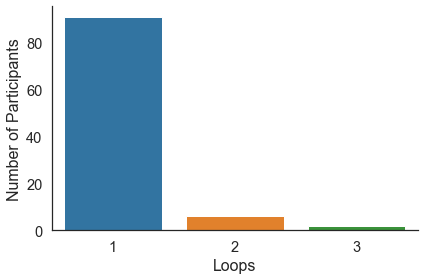

In [3]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot number of loops.
sns.countplot(metadata.Loops, order=[1,2,3], ax=ax)
ax.set(ylabel='Number of Participants')

sns.despine()
plt.tight_layout()

## Section 2: Surveys

In [4]:
## Load survey data.
survey = read_csv(os.path.join('data','surveys.csv'))

#### 2.1 Infrequency Items

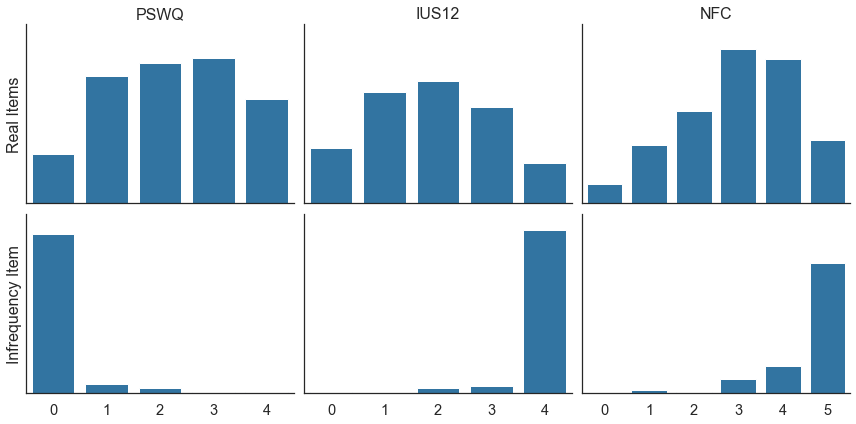

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(2,3,figsize=(12,6))

## Iteratively plot response distributions.
for i, prefix in enumerate(['pswq','ius12','nfc']):
    
    ## Extract responses.
    Y = survey.filter(regex=f'{prefix}-q').values
    order = np.arange(Y.min(), Y.max()+1)
    
    ## Plot response distribution for real items.
    sns.countplot(Y[:,:-1].flatten(), order=order, color='#1f77b4', ax=axes[0,i])
    axes[0,i].set(xticks=[], ylim=(0,500), ylabel='', yticks=[], title=prefix.upper())
    if not i: axes[0,i].set(ylabel='Real Items')
        
    ## Plot response distribution for infrequency items.
    sns.countplot(Y[:,-1].flatten(), order=order, color='#1f77b4', ax=axes[1,i])
    axes[1,i].set(ylim=(0,100), ylabel='', yticks=[])
    if not i: axes[1,i].set(ylabel='Infrequency Item')
    
sns.despine()
plt.tight_layout()

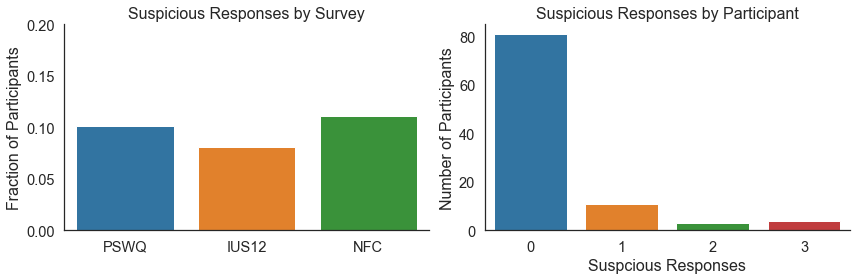

In [6]:
## Score infrequency items.
survey['pswq-infreq'] = np.where(survey['pswq-q17'] > 0, 1, 0)
survey['ius12-infreq'] = np.where(survey['ius12-q13'] < 4, 1, 0)
survey['nfc-infreq'] = np.where(survey['nfc-q16'] < 4, 1, 0)
survey['infreq'] = survey.filter(regex='-infreq').sum(axis=1)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot distribution of scores.
sns.barplot('variable', 'value', data=survey.filter(regex='-infreq').melt(), ci=None, ax=axes[0])
axes[0].set(xticklabels=['PSWQ','IUS12','NFC'], xlabel='', ylabel='Fraction of Participants', 
            ylim=(0,0.2), title='Suspicious Responses by Survey')

## Plot distribution of total scores.
sns.countplot(survey.infreq, order=np.arange(4), ax=axes[1])
axes[1].set(xlabel='Suspcious Responses', ylabel='Number of Participants',
            title='Suspicious Responses by Participant')

sns.despine()
plt.tight_layout()

#### 2.2 Inter-press Intervals

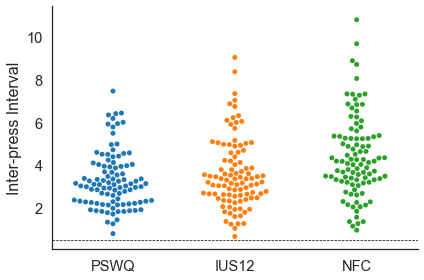

In [7]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot number of loops.
sns.swarmplot('variable', 'value', data=survey.filter(regex='ipi').melt())
ax.set(xticklabels=['PSWQ','IUS12','NFC'], xlabel='', ylabel='Inter-press Interval')
ax.axhline(0.5, color='k', linestyle='--', lw=0.7)

sns.despine()
plt.tight_layout()

## Section 3: Behavior

In [8]:
data = read_csv(os.path.join('data','data.csv'))

#### 3.1 Accuracy

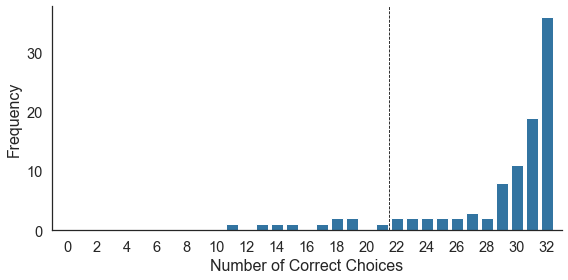

In [9]:
from scipy.stats import binom

## Restrict to final turn of easiest games.
accuracy = data.query('delta >= 20 or delta <= -20').copy()
accuracy = accuracy.query('Horizon == Trial')

## Compute accuracy within participants.
accuracy = accuracy.groupby('Subject').Accuracy.sum().reset_index()

## Apply threshold.
accuracy['Random'] = np.where(accuracy.Accuracy < binom(32,0.5).ppf(0.95), 1, 0)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot distribution.
sns.countplot(accuracy.Accuracy, order=np.arange(33), color='#1f77b4')
ax.axvline(binom(32,0.5).ppf(0.95)+0.5, color='k', linestyle='--', lw=0.8)
ax.set(xticks=np.arange(0,33,2), xticklabels=np.arange(0,33,2), xlim=(-1,33),
       xlabel='Number of Correct Choices', ylabel='Frequency')

sns.despine()
plt.tight_layout()

## Section 4: Rejections

#### 4.1 Assemble metrics

In [10]:
## Assemble metrics.
reject = survey[['Subject','pswq-infreq','ius12-infreq','nfc-infreq','infreq']].merge(accuracy)

## Compute reject score.
reject['Score'] = reject[['infreq','Random']].sum(axis=1)

## Define rejection.
reject['Reject'] = np.where(reject['Score'], 1, 0)

## Save.
reject.to_csv(os.path.join('data','reject.csv'), index=False)
print('Fraction of sample rejected: %0.3f' %reject.Reject.mean()) 

Fraction of sample rejected: 0.212
